In [5]:
import sys
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import csv
import io
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import astropy
from astropy import stats
from scipy import interpolate
import os

[ 1.          1.10526316  1.22160665  1.35019682  1.4923228   1.64940941
  1.82303146  2.01492951  2.22702735  2.46145128  2.72055141  3.00692525
  3.32344369  3.67327987  4.05994091  4.48730311  4.95965081  5.48171932
  6.0587424   6.69650476  7.4014      8.18049473  9.04159944  9.99334675
 11.04527799 12.20793883 13.49298502 14.91329924 16.48312021 18.21818549]
[ 1.          1.10526316  1.22160665  1.35019682  1.4923228   1.64940941
  1.82303146  2.01492951  2.22702735  2.46145128  2.72055141  3.00692525
  3.32344369  3.67327987  4.05994091  4.48730311  4.95965081  5.48171932
  6.0587424   6.69650476  7.4014      8.18049473  9.04159944  9.99334675
 11.04527799 12.20793883 13.49298502 14.91329924 16.48312021 18.21818549]


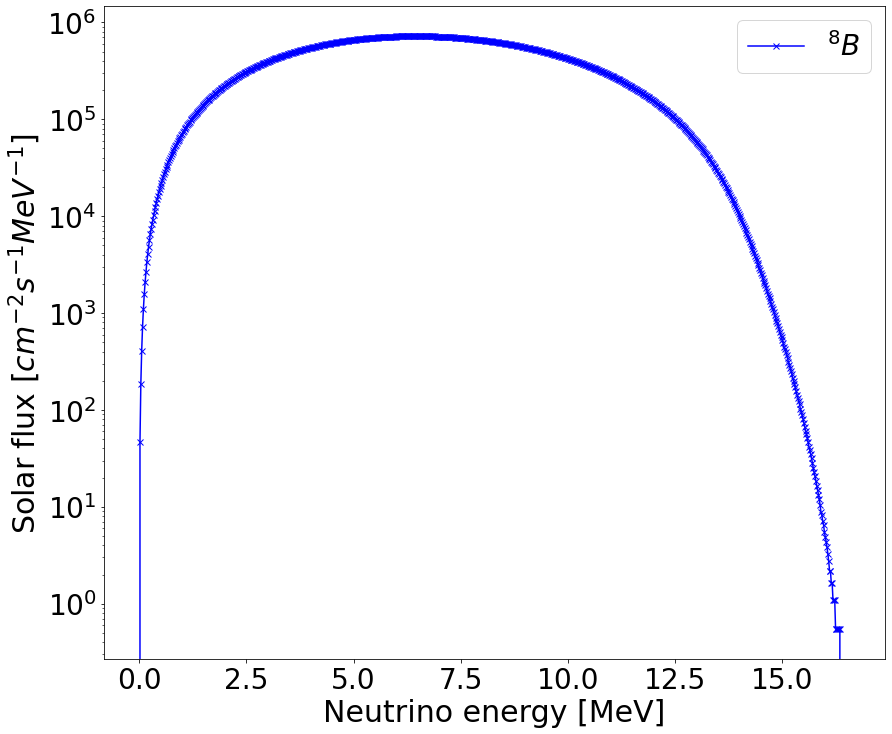

5460000.0
30


In [6]:
os.chdir("../data")  # moves working directory to data folder

EvB8 = np.array([])
EvdataB8 = np.array([])
with open('bahcallB8spectrum.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        temp = row[0].split()
        EvB8 = np.append(EvB8, float(temp[0]))
        EvdataB8 = np.append(EvdataB8, float(temp[1]))
        
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

poptB8, pcovB8 = curve_fit(gaus, EvB8, EvdataB8)
#popthep, pcovhep = curve_fit(gaus, Evhep, Evdatahep) #plt.plot(x,gaus(x,*popt)
        
plt.figure(figsize=(14,12))

fluxB8 = 5.46e6 #/ cm^2 s  B16-GS98 
#fluxhep = 7.98e3

###############################

inEres = 0.1
sigmawidth = 0.5

x = 1
points = np.array([x])
uncer = np.array([inEres*sigmawidth*x])
edges = np.array([x - inEres*sigmawidth*x, x + inEres*sigmawidth*x])

while x < 18:
    xtemp = x*((1+sigmawidth*inEres)/(1-sigmawidth*inEres))  
    uncertemp = inEres*sigmawidth*xtemp
    
    uncer = np.append(uncer, uncertemp)
    points = np.append(points, xtemp)
    edges = np.append(edges, xtemp+ inEres*sigmawidth*xtemp)
    
    x = xtemp
    
print(points)

x = points
bwidth = 2*uncer

print(x)

###############################



tckB8 = interpolate.splrep(EvB8, fluxB8*EvdataB8)
yB8 = interpolate.splev(x, tckB8, der=0)

#tckhep = interpolate.splrep(Evhep, fluxhep*Evdatahep)
#yhep = interpolate.splev(x, tckhep, der=0)


plt.plot(EvB8, EvdataB8*fluxB8, marker="x", color="blue", label=r'${}^{8}B$')
#plt.plot(Evhep, Evdatahep*fluxhep, marker="x", color="red", label=r'hep')
#plt.plot(x, yB8)
#plt.plot(x, yhep)

yB8[yB8 < 0] = 0
#yhep[yhep < 0] = 0

totflux = yB8 #+ yhep

#plt.plot(x, totflux, color='black', linewidth=2)

#totflux = totflux*(x[1]-x[0])

#print(len(yB8), len(yhep))
#print(yhep)

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel(r'Solar flux [$cm^{-2} s^{-1} MeV^{-1}$]',fontsize=30)
plt.yticks(fontsize=28)
plt.yscale('log')

plt.legend(fontsize=28)

plt.show()

np.set_printoptions(suppress=True)

#print('Energy:', repr(x[0:len(totflux)]))
#print('Flux:', repr(totflux))

numflux = fluxB8  #+ fluxhep
print(numflux)

#print(x[totflux == np.max(totflux)])

print(len(x))

[ 0.00089147  0.00077913  0.00060018  0.00033284 -0.00005071 -0.00058551
 -0.00131515 -0.00229267 -0.00358103 -0.00525234 -0.00738556 -0.01006233
 -0.01336091 -0.0173493  -0.02207918 -0.02758257 -0.03387281 -0.04094979
 -0.04880818 -0.05744636 -0.06687399 -0.07711703 -0.08821997 -0.10024585
 -0.1132748  -0.12740174 -0.14273372 -0.15938701 -0.1774839  -0.19714898]
[ 0.00096779  0.0009821   0.00097529  0.00093903  0.00086243  0.00073131
  0.00052735  0.00022701 -0.00019964 -0.00079019 -0.00159109 -0.00265848
 -0.00405832 -0.0058652  -0.00815945 -0.01102238 -0.01452978 -0.01874511
 -0.02371409 -0.02946259 -0.035999   -0.04332062 -0.05142234 -0.06030537
 -0.06998405 -0.08049001 -0.09187361 -0.10420345 -0.11756453 -0.13205587]


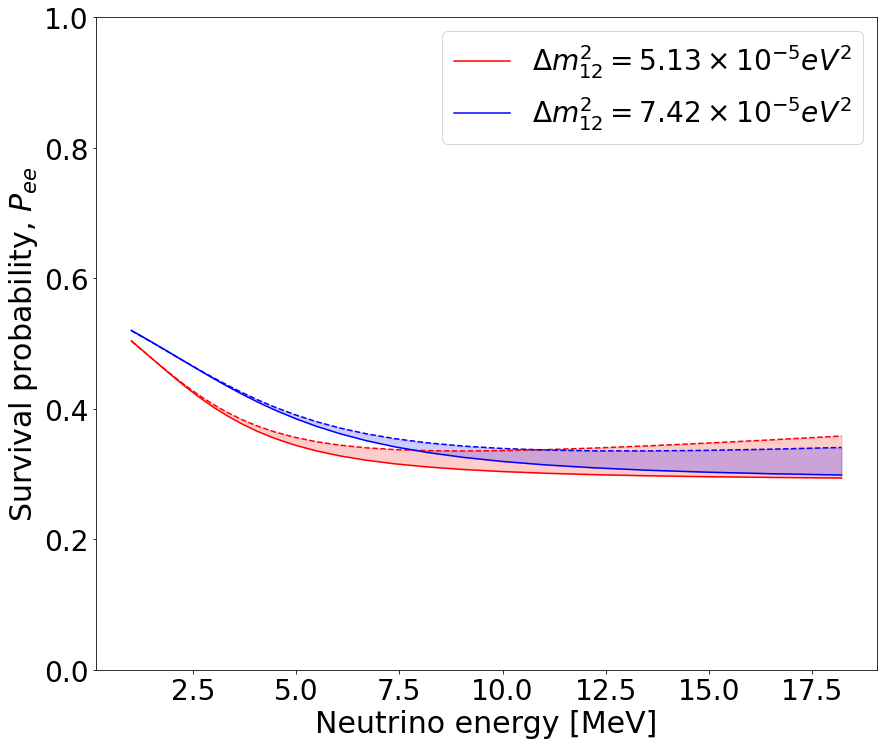

In [78]:
def osc(E, md12):
    
    E = E*1e6
    
    degrad = math.pi/180 # deg.s to rad.s conversion fac.
    
    #E = 6e6 # 6e6 eV, B8 peak
    peS = 92.5e3/1.673e-27 # m-3, e density of Sun at B8 production point 
    peE = 2.8e3/1.673e-27 # m-3, average e density of Earth 

    Gf =  8.958e-44  #eV m3, Fermi constant
    Amsw = 1 # divergence from msw theory
    
    ######################################
    # oscillation parameters:

    #md12 = 7.42e-5 #eV^2, mass-square diff. 
    md13 = 2.515e-3 #eV^2
    
    a12 = 33.4*degrad   # rad, mixing angle
    a13 = 8.57*degrad
    
    s13 = math.sin(a13)
    c13 = math.cos(a13)
    
    s12 = math.sin(a12)
    c12 = math.cos(a12)
    
    s2a12 = math.sin(2*a12)
    c2a12 = math.cos(2*a12)
    
    ######################################
    
    lrS = ((2*2**0.5)*Gf*Amsw*peS*E*(c13**2))/md12 # ratio of oscillation length and refraction length in Sun
    lrE = ((2*2**0.5)*Gf*Amsw*peE*E*(c13**2))/md12 # " " in Earth
    
    c2a12S = (c2a12 - lrS)/(1 - 2*lrS*c2a12 + lrS**2)**0.5 # mixing angle in Sun matter
    c2a12E = (c2a12 - lrE)/(1 - 2*lrE*c2a12 + lrE**2)**0.5 # " " in Earth
    
    s2a12E = np.sin(np.arccos(c2a12E))
    
    freg = 0.5*(c13**2)*lrE*(s2a12E**2)
    
    pd = (c13**4)*(0.5 + 0.5*c2a12S*c2a12) + s13**4
    pn = pd - c2a12S*(c13**2)*freg
    
    asym = (2*c2a12S*(c13**2)*freg)/(2*pd - c2a12S*(c13**2)*freg)
    
    print(asym)

    return pd, pn

plt.figure(figsize=(14,12))

pd1, pn1 = osc(x, 5.13e-5)
pd2, pn2 = osc(x, 7.42e-5)


plt.plot(x, pd1, marker="o", markersize=0, color="red", label=r'$\Delta m_{12}^2 = 5.13 \times 10^{-5} eV^2$')
plt.plot(x, pn1, marker="x", markersize=0, color="red", linestyle='dashed')
plt.fill_between(x, pd1, pn1, color='red', alpha=0.2)

plt.plot(x, pd2, marker="x", markersize=0, color="blue", label=r'$\Delta m_{12}^2 = 7.42 \times 10^{-5} eV^2$')
plt.plot(x, pn2, marker="x", markersize=0, color="blue", linestyle='dashed')
plt.fill_between(x, pd2, pn2, color='blue', alpha=0.2)

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel(r'Survival probability, $P_{ee}$',fontsize=30)
plt.yticks(fontsize=28)
plt.ylim(0,1)
#plt.title("SNOwGLoBES", fontsize=20)

plt.legend(fontsize=28)

plt.show()

#################


In [79]:
npath = '/home/lane/notebook/solar/'
cpath = '/Users/Clara Escanuela/Downloads/'

genpath = npath # general path

def optim_bins(mult_arry):
    
    #import astropy
    #from astropy import stats
    
    width_arry = np.array([])
    
    for arry in mult_arry: 
        width_temp = astropy.stats.freedman_bin_width(arry, return_bins=False)
        width_arry = np.append(width_arry, width_temp)
    
    energy_res = np.max(width_arry)
    print(energy_res)
    flat_arry = np.concatenate(mult_arry, axis=0)
    
    return int(round((np.max(flat_arry) - np.min(flat_arry)) / energy_res, 0))

def hist_weights(rates, data):
    weights = []
    i = 0

    for event in data:
        weight = (rates[i]*np.ones_like(event))/len(event) #fraction = expected events / num of events generated
        weights.append(weight)
        i += 1
    
    return weights

def root_input(path, filename):
    rTree = uproot.open(path + filename)
    
    rTree_event = rTree['mst']
    Ex = np.array(rTree_event['Ex'])
    Ev = np.array(rTree_event['Ev'])
    KEl = np.array(rTree_event['KEl'])
    pdgp = np.array(rTree_event['pdgp'])
    Ep = np.array(rTree_event['Ep'])
    xsec = np.array(rTree_event['xsec'])
    
    return Ex, Ev, KEl, pdgp, Ep, xsec

filename = 'B8_marsum.root'

Ex, Ev, KEl, pdgp, Ep, xsec = root_input(genpath, filename)

In [80]:
n, binedges = np.histogram(Ev, edges, density=True) # bin edges taken

print(n)
print(binedges)

print(totflux)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00005172 0.00087932 0.00309094 0.00778079 0.01488037
 0.02838873 0.05215855 0.08583511 0.12754363 0.1698903  0.19593736
 0.18496139 0.12565266 0.0410102  0.0025313  0.00000607 0.        ]
[ 0.95        1.05        1.16052632  1.28268698  1.41770666  1.56693894
  1.73187988  1.91418303  2.11567598  2.33837872  2.58452384  2.85657898
  3.15727151  3.48961588  3.85694387  4.26293796  4.71166827  5.20763335
  5.75580528  6.36167952  7.03133     7.77147     8.58951947  9.49367941
 10.49301409 11.59754189 12.81833577 14.16763427 15.6589642  17.30727622
 19.12909477]
[ 71087.016       84488.87980044 100217.7031295  118591.59563651
 139906.46685311 164539.10524674 192776.59509006 224936.38195129
 261262.93941211 301857.0689688  346670.09532151 395410.02300231
 447409.35738366 501522.13521499 556083.31499581 608686.39632894
 656040.22247339 693949.20676772 717186.6

30 30
2.8405979671616493


/tmp/ipykernel_4794/3058651637.py:6: RuntimeWarning: divide by zero encountered in true_divide
  crosssec = (n*numflux*np.mean(xsec))/totflux
/tmp/ipykernel_4794/3058651637.py:6: RuntimeWarning: invalid value encountered in true_divide
  crosssec = (n*numflux*np.mean(xsec))/totflux


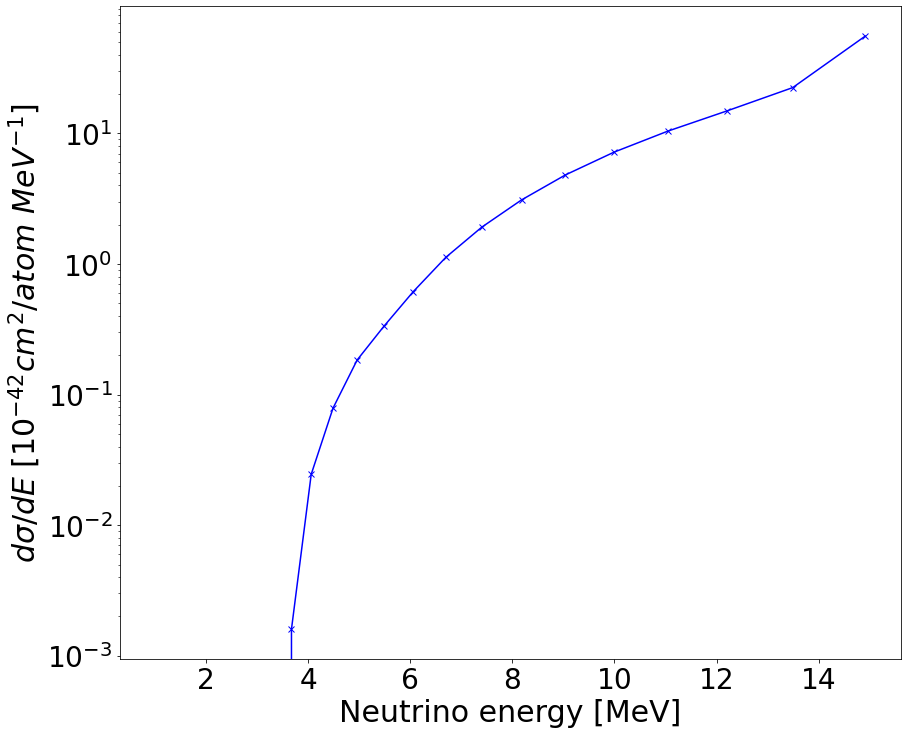

In [81]:
plt.figure(figsize=(14,12))

print(len(n), len(totflux))
print(np.mean(xsec))

crosssec = (n*numflux*np.mean(xsec))/totflux

plt.plot(x, crosssec, marker="x", color="blue")
plt.yscale('log')
plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('$d\sigma/dE$ [$10^{-42} cm^{2}/atom\ MeV^{-1}$]',fontsize=30)
plt.yticks(fontsize=28)
#plt.ylim(0,1)
#plt.title("SNOwGLoBES", fontsize=20)

plt.show()

[ 1.          1.10526316  1.22160665  1.35019682  1.4923228   1.64940941
  1.82303146  2.01492951  2.22702735  2.46145128  2.72055141  3.00692525
  3.32344369  3.67327987  4.05994091  4.48730311  4.95965081  5.48171932
  6.0587424   6.69650476  7.4014      8.18049473  9.04159944  9.99334675
 11.04527799 12.20793883 13.49298502 14.91329924 16.48312021 18.21818549]


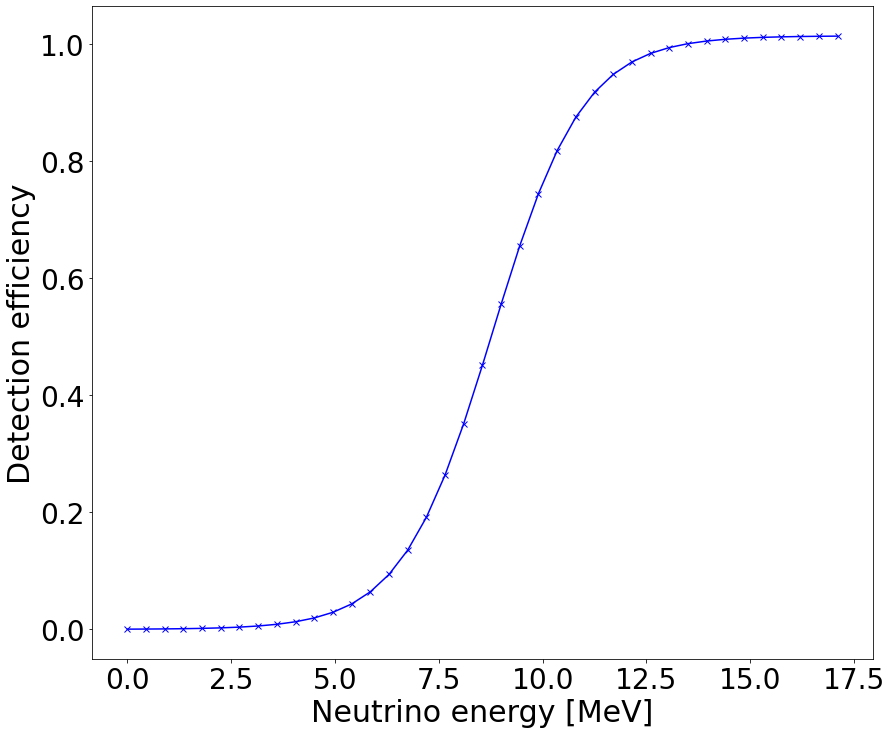

[ 1.          1.10526316  1.22160665  1.35019682  1.4923228   1.64940941
  1.82303146  2.01492951  2.22702735  2.46145128  2.72055141  3.00692525
  3.32344369  3.67327987  4.05994091  4.48730311  4.95965081  5.48171932
  6.0587424   6.69650476  7.4014      8.18049473  9.04159944  9.99334675
 11.04527799 12.20793883 13.49298502 14.91329924 16.48312021 18.21818549]


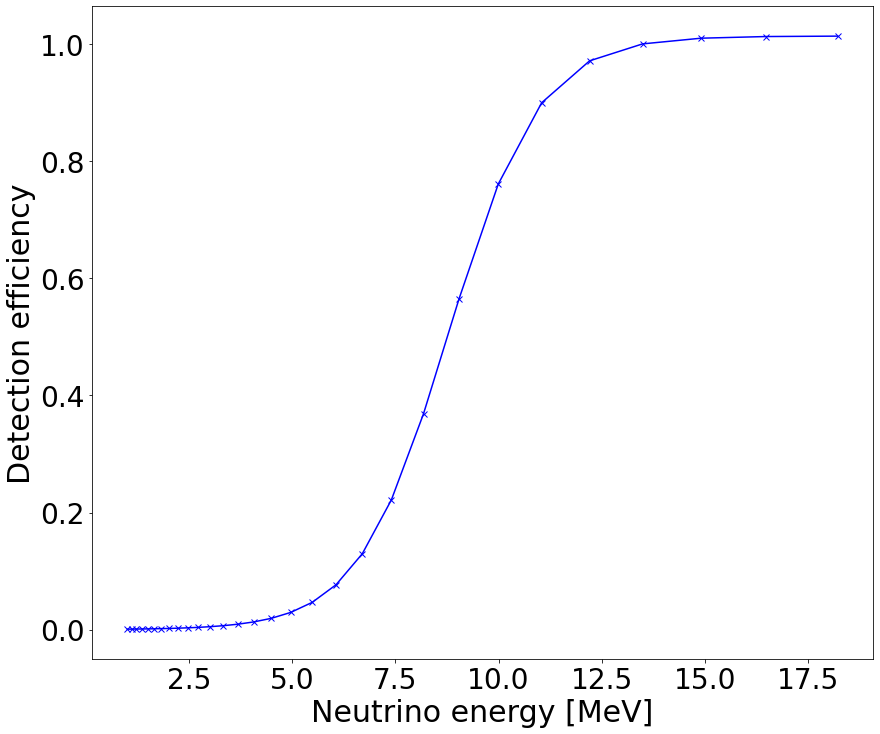

In [82]:
#Efficiency

def sigmoid(x, a, b, c):
    return a/(1 + np.exp(-b*x+c))


energy = np.array([ 0.  ,  0.45,  0.9 ,  1.35,  1.8 ,  2.25,  2.7 ,  3.15,  3.6 ,
        4.05,  4.5 ,  4.95,  5.4 ,  5.85,  6.3 ,  6.75,  7.2 ,  7.65,
        8.1 ,  8.55,  9.  ,  9.45,  9.9 , 10.35, 10.8 , 11.25, 11.7 ,
       12.15, 12.6 , 13.05, 13.5 , 13.95, 14.4 , 14.85, 15.3 , 15.75,
       16.2 , 16.65, 17.1])

params = [1.01391104, 0.91687735, 8.06047126]

plt.figure(figsize=(14,12))

plt.errorbar(energy, sigmoid(energy, *params), color='blue', marker='x', label='0.1')

plt.ylabel('Detection efficiency', fontsize=30)
plt.xlabel(r'Neutrino energy [MeV]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

print(x)

plt.show()


############################

plt.figure(figsize=(14,12))

plt.plot(x, sigmoid(x, *params), color='blue', marker='x', label='0.1')

plt.ylabel('Detection efficiency', fontsize=30)
plt.xlabel(r'Neutrino energy [MeV]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

print(x)

plt.show()

/tmp/ipykernel_4794/1150699334.py:44: RuntimeWarning: invalid value encountered in multiply
  nightval = eff*nt*totflux*crosssec*pn1*gauss_function(convener, a/convE, convE, resol*convE)*fac
/tmp/ipykernel_4794/1150699334.py:53: RuntimeWarning: invalid value encountered in multiply
  dayval = eff*nt*totflux*crosssec*pd1*gauss_function(convener, a/convE, convE, resol*convE)*fac
/tmp/ipykernel_4794/1150699334.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)
/tmp/ipykernel_4794/1150699334.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)
/tmp/ipykernel_4794/1150699334.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)


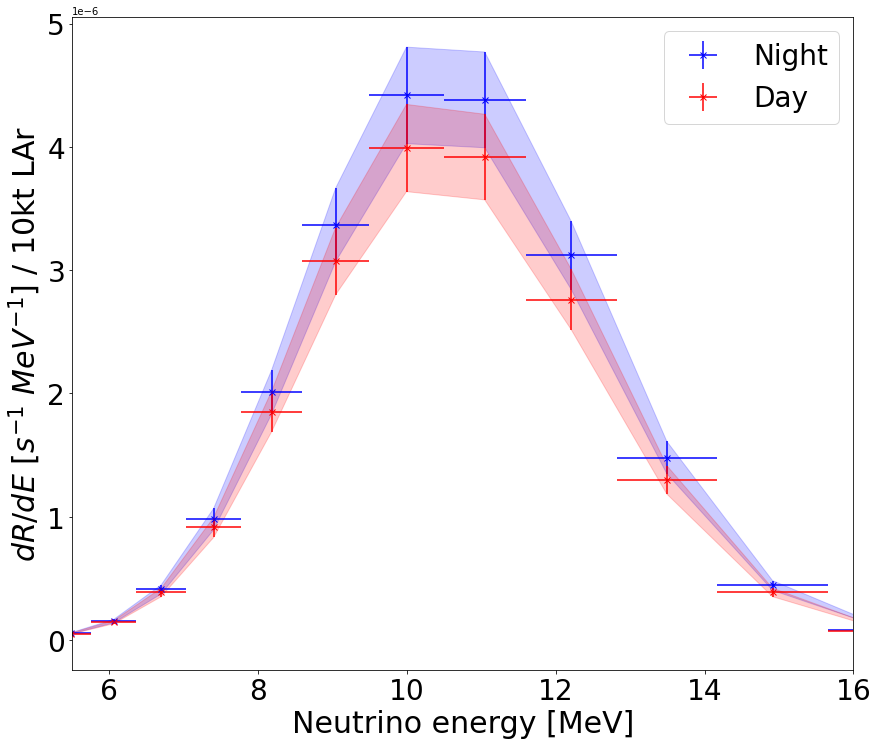

1.951234287944924e-05 2.1703588571853034e-05


In [83]:
plt.figure(figsize=(14,12))

#Gaussian function

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def f(x, A, B):
    return A*x + B

def R_errors(R, eff_std, flux_std, cross_perc):
    
    cross_std = (cross_perc/100)*crosssec
    cross_std[np.isnan(cross_std)] = 0
    cross_std[np.isinf(cross_std)] = 0
    
    R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)
    return np.sqrt(R_var)

resol = inEres
a = np.sqrt(2*np.pi)*resol

sigma = resol
params_lin = [0.99960798, -1.50237267]
eff = sigmoid(x, *params)

nt = 10e31 # number of target atoms in 10kT LAr module
fac = 1e-42 # cross-section factor

intnight_E = np.array([])
intday_E = np.array([])

#totflux = 5.25*10**6  #cm-2s-1, SNO

flux_std = 0.2/5.25
cross_perc = 8 #%
eff_std=0

for i in range(0, len(x)):
    
    convener = f(x, params_lin[0], params_lin[1])
    convE = f(x[i], params_lin[0], params_lin[1])
    
    nightval = eff*nt*totflux*crosssec*pn1*gauss_function(convener, a/convE, convE, resol*convE)*fac
    nightval[np.isnan(nightval)] = 0
    intnight_E = np.append(intnight_E, sum(nightval))
    
for i in range(0, len(x)):
    
    convener = f(x, params_lin[0], params_lin[1])
    convE = f(x[i], params_lin[0], params_lin[1])
    
    dayval = eff*nt*totflux*crosssec*pd1*gauss_function(convener, a/convE, convE, resol*convE)*fac
    
    dayval[np.isnan(dayval)] = 0
    intday_E = np.append(intday_E, sum(dayval))

plt.errorbar(x, intnight_E, xerr=uncer, linestyle='',yerr=R_errors(intnight_E, eff_std, flux_std, cross_perc), marker="x", color="blue", label='Night')
plt.errorbar(x, intday_E, xerr=uncer, linestyle='',yerr=R_errors(intday_E, eff_std, flux_std, cross_perc), marker="x", color="red", label='Day')

plt.fill_between(x, (intnight_E)+R_errors(intnight_E, eff_std, flux_std, cross_perc), (intnight_E)-R_errors(intnight_E, eff_std, flux_std, cross_perc), color='blue', alpha=0.2)
plt.fill_between(x, (intday_E)+R_errors(intday_E, eff_std, flux_std, cross_perc), (intday_E)-R_errors(intday_E, eff_std, flux_std, cross_perc), color='red', alpha=0.2)

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)

plt.ylabel('$dR/dE$ [$s^{-1}\ MeV^{-1}$] / $10$kt LAr',fontsize=30)
plt.yticks(fontsize=28)
plt.legend(fontsize=28)

plt.xlim(5.5,16)

#plt.ylim(0, 1500)
#plt.title("SNOwGLoBES", fontsize=20)
plt.show()

rateday = np.sum(intday_E*bwidth)
ratenight = np.sum(intnight_E*bwidth)
print(rateday, ratenight)

In [84]:
def asymerr(night, day, back):
    #print(night, day)
    
    tempasymmetry = 2*(night-day)/(night+day+2*back)
    #tempuncer = np.sqrt(((2*((2*day + 2*back)/(night + day + 2*back)))**2)*((1/np.sqrt(night))**2) + 
    #                ((2*((2*night + 2*back)/(day + night + 2*back)))**2)*((1/np.sqrt(day))**2) +
    #                ((2*((2*(night - day))/(night + day + 2*back)**2))**2)*((1/np.sqrt(back))**2)) 
    
    tempuncer = np.sqrt((4*(day+back)/(night+day+back)**2)**2*(day) + (4*(night+back)/(night+day+back)**2)**2*(night) 
                        +(4*(night-day)/(night+day+back)**2)**2*(back))
    
    sumasym = np.sum((tempasymmetry/tempuncer**2)[~np.isnan(tempasymmetry/tempuncer**2)])
    sumuncer = np.sum((1/tempuncer**2)[~np.isinf(1/tempuncer**2)])
    
    asymoutput = (sumasym/sumuncer)
    uncerstat = np.sqrt(1/sumuncer)
    
    uncersys = 0.1
    
    unceroutput = np.sqrt((uncerstat/asymoutput)**2 + uncersys**2)
    
    return asymoutput*100, asymoutput*unceroutput*100, tempasymmetry, tempuncer

back = 1e0

#expo_time = np.linspace(1, 20, 19)

years = 5
expo = years*3.14e7*4

#asym_array = np.array([])
#uncer_array = np.array([])

#for i in range(0, len(expo_time)):
#    asym_a, uncer_a, asymarray_a, uncerarray_a = asymerr(ratenight*expo_time[i]*3.14e7, rateday*expo_time[i]*3.14e7, back)
#    asym_array = np.append(asym_array, asym_a)
#    uncer_array = np.append(uncer_array, uncer_a)

asymfin, uncerfin, asymarray, uncerarray = asymerr(ratenight*expo, rateday*expo, back)

print("Night-day asymmetry:", asymfin, "+/-", uncerfin, "%")
#print(rateday*expo)

#print(osc(10, 5.13e-5))
#print(asym_array)

Night-day asymmetry: 10.632181843246496 +/- 1.6397914972817524 %


In [85]:
def osc(md12):
    
    degrad = math.pi/180 # deg.s to rad.s conversion fac.
    
    E = 10.5e6 # 6e6 eV, B8 peak
    peS = 92.5e3/1.673e-27 # m-3, e density of Sun at B8 production point 
    peE = 2.8e3/1.673e-27 # m-3, average e density of Earth 

    Gf =  8.958e-44  #eV m3, Fermi constant
    Amsw = 1 # divergence from msw theory
    
    ######################################
    # oscillation parameters:

    #md12 = 7.42e-5 #eV^2, mass-square diff. 
    md13 = 2.515e-3 #eV^2
    
    a12 = 33.4*degrad   # rad, mixing angle
    a13 = 8.57*degrad
    
    s13 = math.sin(a13)
    c13 = math.cos(a13)
    
    s12 = math.sin(a12)
    c12 = math.cos(a12)
    
    s2a12 = math.sin(2*a12)
    c2a12 = math.cos(2*a12)
    
    ######################################
    
    lrS = ((2*2**0.5)*Gf*Amsw*peS*E*(c13**2))/md12 # ratio of oscillation length and refraction length in Sun
    lrE = ((2*2**0.5)*Gf*Amsw*peE*E*(c13**2))/md12 # " " in Earth
    
    c2a12S = (c2a12 - lrS)/(1 - 2*lrS*c2a12 + lrS**2)**0.5 # mixing angle in Sun matter
    c2a12E = (c2a12 - lrE)/(1 - 2*lrE*c2a12 + lrE**2)**0.5 # " " in Earth
    
    s2a12E = np.sin(np.arccos(c2a12E))
    
    freg = 0.5*(c13**2)*lrE*(s2a12E**2)
    
    pd = (c13**4)*(0.5 + 0.5*c2a12S*c2a12) + s13**4
    
    asym = (2*c2a12S*(c13**2)*freg)/(2*pd - c2a12S*(c13**2)*freg)
    
    return asym

def asym(years, vol):
    
    resol = inEres
    a = np.sqrt(2*np.pi)*resol

    sigma = resol
    params_lin = [0.99960798, -1.50237267]
    eff = sigmoid(x, *params)

    nt = vol*10e31 # number of target atoms in 10kT LAr module
    fac = 1e-42 # cross-section factor

    intnight_E = np.array([])
    intday_E = np.array([])

    #totflux = 5.25*10**6  #cm-2s-1, SNO

    flux_std = 0.2/5.25
    cross_perc = 8 #%
    eff_std=0

    for i in range(0, len(x)):
    
        convener = f(x, params_lin[0], params_lin[1])
        convE = f(x[i], params_lin[0], params_lin[1])
    
        nightval = eff*nt*totflux*crosssec*pn1*gauss_function(convener, a/convE, convE, resol*convE)*fac
        nightval[np.isnan(nightval)] = 0
        intnight_E = np.append(intnight_E, sum(nightval))
    
    for i in range(0, len(x)):
    
        convener = f(x, params_lin[0], params_lin[1])
        convE = f(x[i], params_lin[0], params_lin[1])
    
        dayval = eff*nt*totflux*crosssec*pd1*gauss_function(convener, a/convE, convE, resol*convE)*fac
    
        dayval[np.isnan(dayval)] = 0
        intday_E = np.append(intday_E, sum(dayval))

    upbndn = np.sum((intnight_E + R_errors(intnight_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intnight_E + R_errors(intnight_E, eff_std, flux_std, cross_perc)))]) 
    lowbndn = np.sum((intnight_E - R_errors(intnight_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intnight_E - R_errors(intnight_E, eff_std, flux_std, cross_perc)))])
    
    upbndd = np.sum((intday_E + R_errors(intday_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intday_E + R_errors(intday_E, eff_std, flux_std, cross_perc)))])
    lowbndd = np.sum((intday_E - R_errors(intday_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intday_E - R_errors(intday_E, eff_std, flux_std, cross_perc)))])
    
    rateday = np.sum(intday_E*bwidth)
    ratenight = np.sum(intnight_E*bwidth)
    
    
    expo = years*3.14e7

    asym, uncer, asymarray, uncerarray = asymerr(ratenight*expo, rateday*expo, back)
    asymup, uncerup, asymarrayup, uncerarrayup = asymerr(upbndn*expo, upbndd*expo, back)
    asymlow, uncerlow, asymarraylow, uncerarraylow = asymerr(lowbndn*expo, lowbndd*expo, back)
    
    asymexp = -osc(7.42e-5)*100
    
    return ((asym-asymexp)**2/uncer**2)**0.5, ((asymup-asymexp)**2/uncerup**2)**0.5, ((asymlow-asymexp)**2/uncerlow**2)**0.5, asym, uncer

yarray = np.arange(0.01, 30, 0.01)
sarray = np.array([])
sarrayup = np.array([])
sarraylow = np.array([])

for elem in yarray:
    temp = asym(elem, 1)
    
    sarray = np.append(sarray, temp[0])
    sarrayup = np.append(sarrayup, temp[1])
    sarraylow = np.append(sarraylow, temp[2])
    
sarray40 = np.array([])
sarrayup40 = np.array([])
sarraylow40 = np.array([])

for elem in yarray:
    temp = asym(elem, 4)
    
    sarray40 = np.append(sarray40, temp[0])
    sarrayup40 = np.append(sarrayup40, temp[1])
    sarraylow40 = np.append(sarraylow40, temp[2])
    
sarray70 = np.array([])
sarrayup70 = np.array([])
sarraylow70 = np.array([])

for elem in yarray:
    temp = asym(elem, 7)
    
    sarray70 = np.append(sarray70, temp[0])
    sarrayup70 = np.append(sarrayup70, temp[1])
    sarraylow70 = np.append(sarraylow70, temp[2])
    

/tmp/ipykernel_4794/150454160.py:74: RuntimeWarning: invalid value encountered in multiply
  nightval = eff*nt*totflux*crosssec*pn1*gauss_function(convener, a/convE, convE, resol*convE)*fac
/tmp/ipykernel_4794/150454160.py:83: RuntimeWarning: invalid value encountered in multiply
  dayval = eff*nt*totflux*crosssec*pd1*gauss_function(convener, a/convE, convE, resol*convE)*fac
/tmp/ipykernel_4794/1150699334.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)


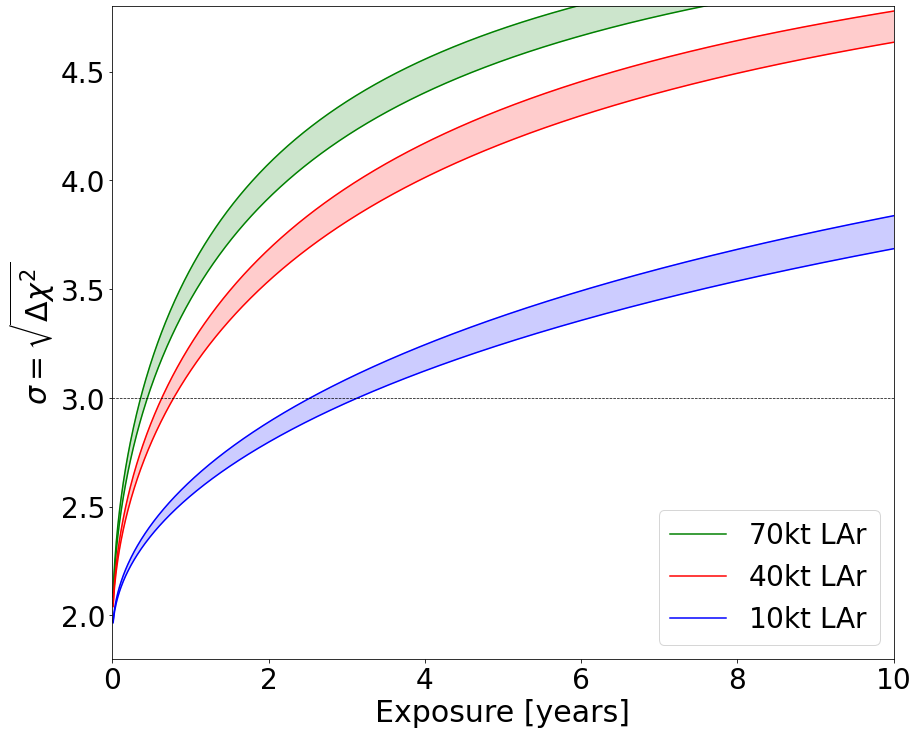

In [86]:
def chisquar(obs, uncer, exp):
    
    chisquar = ((obs - exp)**2)/uncer**2
    
    return chisquar

#KL = [7.54e-5, 0.18e-5] # measurement and error
#asymDUNE = [osc(5.13e-5), osc(5.13e-5)*0.15]
globsolar = [5.13e-5, 1.25e-5]

#chiKL = chisquar(KL[0], KL[1], x)
#chiDUNE = chisquar(asymDUNE[0], asymDUNE[1], osc(x))
chiGS = chisquar(globsolar[0], globsolar[1], 7.54e-5) # global solar

y = chiGS**0.5


plt.figure(figsize=(14,12))

plt.plot(yarray, sarrayup70+y, color='green', marker='x', markersize=0, label='$70$kt LAr')
plt.plot(yarray, sarraylow70+y, color='green', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow70+y, sarrayup70+y, color='green', alpha=0.2)

#########################

plt.plot(yarray, sarrayup40+y, color='red', marker='x', markersize=0, label='$40$kt LAr')
plt.plot(yarray, sarraylow40+y, color='red', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow40+y, sarrayup40+y, color='red', alpha=0.2)

########################

#plt.plot(yarray, sarray, color='blue', marker='x')
plt.plot(yarray, sarrayup+y, color='blue', marker='x', markersize=0, label='$10$kt LAr')
plt.plot(yarray, sarraylow+y, color='blue', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow+y, sarrayup+y, color='blue', alpha=0.2)

plt.ylabel(r'$\sigma = \sqrt{\Delta \chi^2}$', fontsize=30)
plt.xlabel(r'Exposure [years]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.axhline(y=3, color='black', linestyle='--', linewidth=0.7)
plt.axhline(y=5, color='black', linestyle='--', linewidth=0.7)

plt.xlim(0,10)
plt.ylim(1.8,4.8)

#plt.yscale('log')

plt.legend(fontsize=28)
plt.show()



In [87]:
def asym(years, vol):
    
    resol = inEres
    a = np.sqrt(2*np.pi)*resol

    sigma = resol
    params_lin = [0.99960798, -1.50237267]
    eff = sigmoid(x, *params)

    nt = vol*10e31 # number of target atoms in 10kT LAr module
    fac = 1e-42 # cross-section factor

    intnight_E = np.array([])
    intday_E = np.array([])

    #totflux = 5.25*10**6  #cm-2s-1, SNO

    flux_std = 0.2/5.25
    cross_perc = 8 #%
    eff_std=0

    for i in range(0, len(x)):
    
        convener = f(x, params_lin[0], params_lin[1])
        convE = f(x[i], params_lin[0], params_lin[1])
    
        nightval = eff*nt*totflux*crosssec*pn1*gauss_function(convener, a/convE, convE, resol*convE)*fac
        nightval[np.isnan(nightval)] = 0
        intnight_E = np.append(intnight_E, sum(nightval))
    
    for i in range(0, len(x)):
    
        convener = f(x, params_lin[0], params_lin[1])
        convE = f(x[i], params_lin[0], params_lin[1])
    
        dayval = eff*nt*totflux*crosssec*pd1*gauss_function(convener, a/convE, convE, resol*convE)*fac
    
        dayval[np.isnan(dayval)] = 0
        intday_E = np.append(intday_E, sum(dayval))

    upbndn = np.sum((intnight_E + R_errors(intnight_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intnight_E + R_errors(intnight_E, eff_std, flux_std, cross_perc)))]) 
    lowbndn = np.sum((intnight_E - R_errors(intnight_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intnight_E - R_errors(intnight_E, eff_std, flux_std, cross_perc)))])
    
    upbndd = np.sum((intday_E + R_errors(intday_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intday_E + R_errors(intday_E, eff_std, flux_std, cross_perc)))])
    lowbndd = np.sum((intday_E - R_errors(intday_E, eff_std, flux_std, 
            cross_perc)*bwidth)[~np.isnan((intday_E - R_errors(intday_E, eff_std, flux_std, cross_perc)))])
    
    rateday = np.sum(intday_E*bwidth)
    ratenight = np.sum(intnight_E*bwidth)
    
    
    expo = years*3.14e7

    asym, uncer, asymarray, uncerarray = asymerr(ratenight*expo, rateday*expo, back)
    asymup, uncerup, asymarrayup, uncerarrayup = asymerr(upbndn*expo, upbndd*expo, back)
    asymlow, uncerlow, asymarraylow, uncerarraylow = asymerr(lowbndn*expo, lowbndd*expo, back)
    
    asymexp = 0
    
    return ((asym-asymexp)**2/uncer**2)**0.5, ((asymup-asymexp)**2/uncerup**2)**0.5, ((asymlow-asymexp)**2/uncerlow**2)**0.5, asym, uncer

yarray = np.arange(0.01, 30, 0.01)
sarray = np.array([])
sarrayup = np.array([])
sarraylow = np.array([])

for elem in yarray:
    temp = asym(elem, 1)
    
    sarray = np.append(sarray, temp[0])
    sarrayup = np.append(sarrayup, temp[1])
    sarraylow = np.append(sarraylow, temp[2])
    
sarray40 = np.array([])
sarrayup40 = np.array([])
sarraylow40 = np.array([])

for elem in yarray:
    temp = asym(elem, 4)
    
    sarray40 = np.append(sarray40, temp[0])
    sarrayup40 = np.append(sarrayup40, temp[1])
    sarraylow40 = np.append(sarraylow40, temp[2])
    
sarray70 = np.array([])
sarrayup70 = np.array([])
sarraylow70 = np.array([])

for elem in yarray:
    temp = asym(elem, 7)
    
    sarray70 = np.append(sarray70, temp[0])
    sarrayup70 = np.append(sarrayup70, temp[1])
    sarraylow70 = np.append(sarraylow70, temp[2])
    



/tmp/ipykernel_4794/3083079392.py:27: RuntimeWarning: invalid value encountered in multiply
  nightval = eff*nt*totflux*crosssec*pn1*gauss_function(convener, a/convE, convE, resol*convE)*fac
/tmp/ipykernel_4794/3083079392.py:36: RuntimeWarning: invalid value encountered in multiply
  dayval = eff*nt*totflux*crosssec*pd1*gauss_function(convener, a/convE, convE, resol*convE)*fac
/tmp/ipykernel_4794/1150699334.py:17: RuntimeWarning: invalid value encountered in true_divide
  R_var = R**2*((eff_std/eff)**2+(flux_std)**2+(cross_std/crosssec)**2)


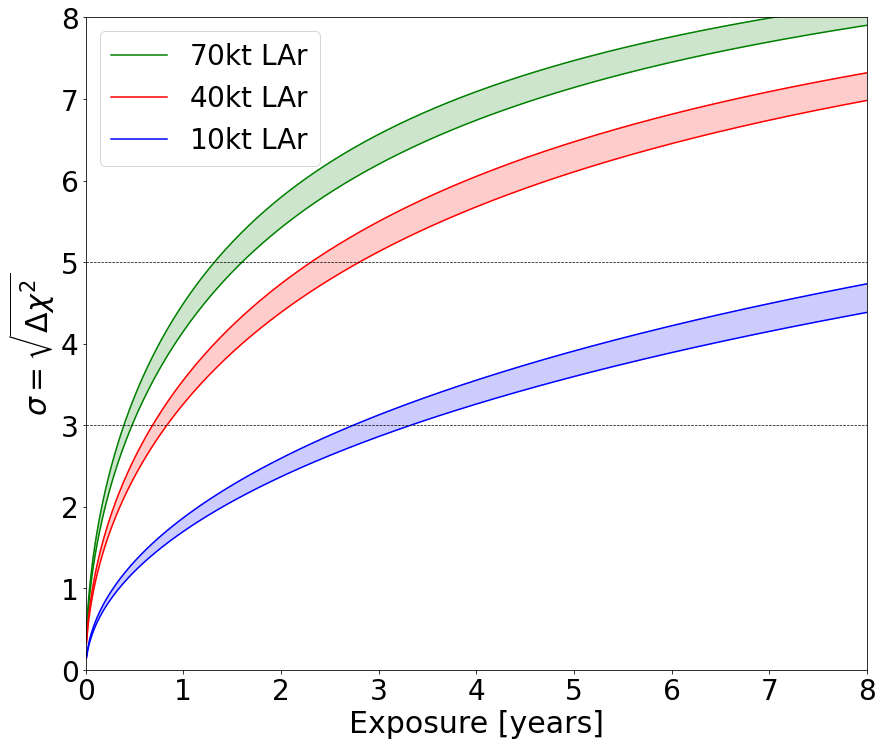

In [88]:

plt.figure(figsize=(14,12))

plt.plot(yarray, sarrayup70, color='green', marker='x', markersize=0, label='$70$kt LAr')
plt.plot(yarray, sarraylow70, color='green', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow70, sarrayup70, color='green', alpha=0.2)

#########################

plt.plot(yarray, sarrayup40, color='red', marker='x', markersize=0, label='$40$kt LAr')
plt.plot(yarray, sarraylow40, color='red', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow40, sarrayup40, color='red', alpha=0.2)

########################

#plt.plot(yarray, sarray, color='blue', marker='x')
plt.plot(yarray, sarrayup, color='blue', marker='x', markersize=0, label='$10$kt LAr')
plt.plot(yarray, sarraylow, color='blue', marker='x', markersize=0)

plt.fill_between(yarray, sarraylow, sarrayup, color='blue', alpha=0.2)

plt.ylabel(r'$\sigma = \sqrt{\Delta \chi^2}$', fontsize=30)
plt.xlabel(r'Exposure [years]', fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.axhline(y=3, color='black', linestyle='--', linewidth=0.7)
plt.axhline(y=5, color='black', linestyle='--', linewidth=0.7)

plt.xlim(0,8)
plt.ylim(0,8)

#plt.yscale('log')

plt.legend(fontsize=28)
plt.show()

In [89]:
print(10.63*0.13)

1.3819000000000001
